In [178]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'Total_Any_Tobacco_7days'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=5000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [179]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [181]:
# Load ADNI model

import pickle

adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weights0.pkl', 'rb'))
# adni = {'coef': None}
# adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corr.pkl', 'rb'))


list(adni.keys())

['intercept', 'coef']

In [138]:
dct['demos'][3][:20]

array([65., 69., 68., 64., 64., 68., 64., 66., 68., 64., 65., 72., 74.,
       63., 64., 67., 75., 67., 63., 65.])

In [182]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = 0 #adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-45.242360522778206
0.7894325670010313


In [183]:
# Height and AD https://pmc.ncbi.nlm.nih.gov/articles/PMC6037293/
# Observational studies have linked increased adult height with better cognitive performance and reduced 
# risk of Alzheimer’s disease (AD). It is unclear whether the associations are due to shared biological 
# processes that influence height and AD or due to confounding by early life exposures or environmental factors.

vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    ndemo[1] = 1*np.ones(len(ndemo[1]))
    # ndemo[0] += 15
    # ndemo[4] = 0*np.ones(len(ndemo[4]))
    # ndemo[4] -= 15
    
    nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20
    
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-42.72706431108192
0.7379129564340079


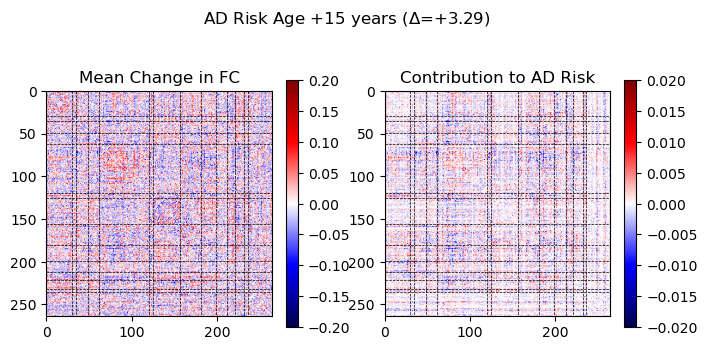

In [175]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,4))

subject = 'Age +15 years'
delta = '+3.29'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')

norm1 = TwoSlopeNorm(vmax=0.2, vmin=-0.2, vcenter=0)
norm2 = TwoSlopeNorm(vmax=0.02, vmin=-0.02, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
fig.savefig(f'/home/anton/Documents/Yale/HCP/Figures/FCChanges/{tit}.pdf')

In [176]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)

for i in range(len(divis)-1):
    for j in range(i,len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        val = np.mean(W[r1a:r1b,r2a:r2b])
        vals.append(val)
        val = np.sum(W[r1a:r1b,r2a:r2b])
        sums.append(val)
        labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

Age_+15_years
Individual ROIs
14023 60 74 AUD DMN -0.01714438027953813
27011 139 185 VIS SAL 0.015712314162328645
16674 73 177 DMN FRNT -0.015203390734658864
16856 74 170 DMN FRNT -0.014640652335603462
14021 60 72 AUD DMN -0.014202975726037336
17789 79 173 DMN FRNT -0.01418377474296583
6609 26 123 SMTH MEM 0.013945665009304114
17294 76 233 DMN CBL -0.013772960280451546
Networks Mean
-0.0016687110181570187 SMTM-VTRL
-0.0015260110416008285 MEM-MEM
0.0014222677811303217 MEM-VTRL
0.0012793981177921861 VIS-CBL
0.0012008023513016442 SMTM-SUB
-0.0011613677084942496 AUD-AUD
0.0010811828916122519 AUD-CBL
0.0009758527580742366 MEM-CBL
Networks Sum
0.9600526235731848 DMN-DMN
-0.5631031688655124 DMN-VIS
0.42508500321995607 SMTH-FRNT
0.2774789269110099 SMTH-SAL
-0.24952906502528863 CNG-DMN
0.24486674901692243 VIS-SAL
-0.24261121008683006 SMTH-VTRL
-0.22428469286856376 AUD-FRNT


In [177]:
np.sum(sums)

np.float64(0.32671763258463776)